偵測到電腦核心數 = 16
522729 OD pairs
723 zones
10132 nodes
25370 links
Reading the network data took 3.39 secs
==== 開始交通指派 ====
Iteration 1 no improvement in gap: inf count: 1
    Iteration 1 completed :)


C:\Users\Allen\AppData\Local\Temp\ipykernel_17392\2285932969.py:190: RuntimeWarning: invalid value encountered in power
  tmpCost = linkSet[l].fft * (1 + linkSet[l].alpha * ((tmpFlow / linkSet[l].capacity) ** linkSet[l].beta))
c:\Users\Allen\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


fsolve 無法找到有效步長，改用 fallback 步長
Iteration 2 improved gap: 0.79589 count reset to 0
    Iteration 2 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 3 improved gap: 0.62558 count reset to 0
    Iteration 3 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 4 improved gap: 0.47661 count reset to 0
    Iteration 4 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 5 improved gap: 0.35791 count reset to 0
    Iteration 5 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 6 improved gap: 0.27505 count reset to 0
    Iteration 6 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 7 improved gap: 0.17457 count reset to 0
    Iteration 7 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 8 improved gap: 0.1289 count reset to 0
    Iteration 8 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 9 improved gap: 0.06402 count reset to 0
    Iteration 9 completed :)
fsolve 無法找到有效步長，改用 fallback 步長
Iteration 10 improved gap: 0.00982 count reset to 0
    Iteration 10 completed :)


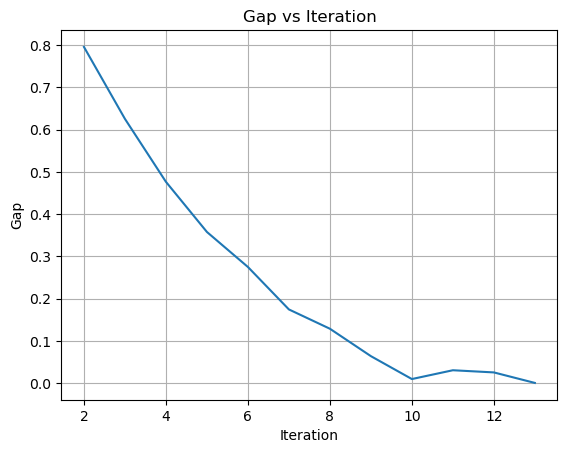

==== Network Health Check ====
完全孤立節點: 0
目前未標定 predecessor 的節點數: 22
所有流量皆為 0？ False


In [3]:
# -*- coding: utf-8 -*-
"""
Created on Sun May 28 21:09:46 2017 (modified for performance)
Author: Pramesh Kumar (original)
        Modified by ChatGPT (2025-04-15)

效能改進措施：
 1. 平行化 AON 分配（loadAON_parallel）
 2. 程式內部部分小幅向量化與簡化（例如 updateTravelTime）
 3. 後續可考慮用 numba 進行 JIT 加速（目前未做大幅調整）
"""

import math
import time
import heapq
import numpy as np
from scipy import optimize
from scipy.optimize import fsolve
import copy
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt

inputLocation = "Taipei/"

# 動態偵測可用 CPU 核心數
import os
CPU_COUNT = os.cpu_count() or 1
print(f"偵測到電腦核心數 = {CPU_COUNT}")

# -------------------------------
# 基本資料結構與初始化
# -------------------------------
class Zone:
    def __init__(self, _tmpIn):
        self.zoneId = _tmpIn[0]
        self.lat = 0
        self.lon = 0
        self.destList = []


class Node:
    '''
    此類別儲存網絡中節點的資訊
    '''
    def __init__(self, _tmpIn):
        self.Id = _tmpIn[0]
        self.lat = 0
        self.lon = 0
        self.outLinks = []
        self.inLinks = []
        self.label = float("inf")
        self.pred = ""
        self.inDegree = 0
        self.outDegree = 0
        self.order = 0  # 拓樸排序順序
        self.wi = 0.0  # Dial 演算法中節點權重
        self.xi = 0.0  # Dial 演算法中節點流量
        self.xj = 0.0  # 新增：用於流量回溯時累計需求


class Link:
    '''
    此類別儲存網絡中連結的資訊
    '''
    def __init__(self, _tmpIn):
        self.tailNode = _tmpIn[0]
        self.headNode = _tmpIn[1]
        self.capacity = float(_tmpIn[2])  # veh per hour
        self.length = float(_tmpIn[3])      # Length
        self.fft = float(_tmpIn[4])         # Free flow travel time (min)
        self.beta = float(_tmpIn[6])
        self.alpha = float(_tmpIn[5])
        self.speedLimit = float(_tmpIn[7])
        #self.toll = float(_tmpIn[9])
        #self.linkType = float(_tmpIn[10])
        self.flow = 0.0
        self.cost = float(_tmpIn[4])
        self.logLike = 0.0
        self.reasonable = True  # 用於 Dial 隨機分配
        self.wij = 0.0  # Dial 演算法中連結權重
        self.xij = 0.0  # Dial 演算法中該連結上流量累計


class Demand:
    def __init__(self, _tmpIn):
        self.fromZone = _tmpIn[0]
        self.toNode = _tmpIn[1]
        self.demand = float(_tmpIn[2])


def readDemand():
    inFile = open(inputLocation + "demand.dat")
    tmpIn = inFile.readline().strip().split("\t")
    for x in inFile:
        tmpIn = x.strip().split("\t")
        tripSet[tmpIn[0], tmpIn[1]] = Demand(tmpIn)
        if tmpIn[0] not in zoneSet:
            zoneSet[tmpIn[0]] = Zone([tmpIn[0]])
        if tmpIn[1] not in zoneSet:
            zoneSet[tmpIn[1]] = Zone([tmpIn[1]])
        if tmpIn[1] not in zoneSet[tmpIn[0]].destList:
            zoneSet[tmpIn[0]].destList.append(tmpIn[1])
    inFile.close()
    print(len(tripSet), "OD pairs")
    print(len(zoneSet), "zones")


def readNetwork():
    inFile = open(inputLocation + "network.dat")
    tmpIn = inFile.readline().strip().split("\t")
    for x in inFile:
        tmpIn = x.strip().split("\t")
        linkSet[tmpIn[0], tmpIn[1]] = Link(tmpIn)
        if tmpIn[0] not in nodeSet:
            nodeSet[tmpIn[0]] = Node(tmpIn[0])
        if tmpIn[1] not in nodeSet:
            nodeSet[tmpIn[1]] = Node(tmpIn[1])
        if tmpIn[1] not in nodeSet[tmpIn[0]].outLinks:
            nodeSet[tmpIn[0]].outLinks.append(tmpIn[1])
        if tmpIn[0] not in nodeSet[tmpIn[1]].inLinks:
            nodeSet[tmpIn[1]].inLinks.append(tmpIn[0])
    inFile.close()
    print(len(nodeSet), "nodes")
    print(len(linkSet), "links")


# -------------------------------
# 初始讀取
# -------------------------------
readStart = time.time()

tripSet = {}
zoneSet = {}
linkSet = {}
nodeSet = {}

readDemand()
readNetwork()

originZones = set([k[0] for k in tripSet])
print("Reading the network data took", round(time.time() - readStart, 2), "secs")

# -------------------------------
# Dijkstra 及相關函數（原始版本改為局部版本）
# -------------------------------
def DijkstraHeap(origin):
    """
    計算從 origin 到所有節點的最短路徑，
    直接更新 global nodeSet（用於 deterministic loading）
    """
    for n in nodeSet:
        nodeSet[n].label = float("inf")
        nodeSet[n].pred = ""
    nodeSet[origin].label = 0.0
    nodeSet[origin].pred = "NA"
    SE = [(0, origin)]
    while SE:
        currentNode = heapq.heappop(SE)[1]
        currentLabel = nodeSet[currentNode].label
        for toNode in nodeSet[currentNode].outLinks:
            link = (currentNode, toNode)
            newNode = toNode
            newPred = currentNode
            existingLabel = nodeSet[newNode].label
            newLabel = currentLabel + linkSet[link].cost
            if newLabel < existingLabel:
                heapq.heappush(SE, (newLabel, newNode))
                nodeSet[newNode].label = newLabel
                nodeSet[newNode].pred = newPred


def updateTravelTime():
    """
    更新連結的 travel time，使用 BPR 公式
    """
    for l in linkSet:
        ratio = linkSet[l].flow / linkSet[l].capacity
        linkSet[l].cost = linkSet[l].fft * (1 + linkSet[l].alpha * (ratio ** linkSet[l].beta))


def findAlpha(x_bar):
    """
    使用非約束最佳化找出 Frank-Wolfe 演算法中的步長，
    如果 fsolve 失敗，則使用 fallback 固定步長
    """
    def df(alpha):
        sum_derivative = 0
        for l in linkSet:
            tmpFlow = linkSet[l].flow + alpha * (x_bar[l] - linkSet[l].flow)
            tmpCost = linkSet[l].fft * (1 + linkSet[l].alpha * ((tmpFlow / linkSet[l].capacity) ** linkSet[l].beta))
            sum_derivative += (x_bar[l] - linkSet[l].flow) * tmpCost
        return sum_derivative
    sol = optimize.root(df, np.array([0.1]))
    sol2 = fsolve(df, np.array([0.1]))
    if not sol.success or not (0 < sol2[0] <= 1):
        print("fsolve 無法找到有效步長，改用 fallback 步長")
        return 0.2
    return max(0.1, min(1, sol2[0]))


def tracePreds(dest):
    """
    回溯獲取從起點至 dest 的最短路徑
    """
    prevNode = nodeSet[dest].pred
    spLinks = []
    visited = set()
    while nodeSet[dest].pred != "NA":
        if dest in visited:
            print(f"循環偵測：{dest} 無法正確回溯")
            break
        visited.add(dest)
        spLinks.append((prevNode, dest))
        if prevNode == "":
            print(f"警告：節點 {dest} 的 pred 是空字串")
            break
        dest = prevNode
        prevNode = nodeSet[dest].pred
    return spLinks



def loadAON():
    """
    傳統 All-or-Nothing 分配：針對每個原點執行 Dijkstra，
    並根據最短路徑分配需求，回傳總的 SPTT 與輔助流量 x_bar
    """
    x_bar = {l: 0.0 for l in linkSet}
    SPTT = 0.0
    for r in originZones:
        DijkstraHeap(r)
        for s in zoneSet[r].destList:
            try:
                dem = tripSet[r, s].demand
            except KeyError:
                dem = 0.0
            SPTT += nodeSet[s].label * dem
            if r != s:
                for spLink in tracePreds(s):
                    x_bar[spLink] += dem
    return SPTT, x_bar


# -------------------------------
# 平行化 All-or-Nothing 分配（Performance Improvement）
# -------------------------------
def DijkstraHeap_local(origin, local_nodeSet, local_linkSet):
    """
    局部版本的 Dijkstra，操作拷貝後的資料
    """
    for n in local_nodeSet:
        local_nodeSet[n].label = float("inf")
        local_nodeSet[n].pred = ""
    local_nodeSet[origin].label = 0.0
    local_nodeSet[origin].pred = "NA"
    SE = [(0, origin)]
    while SE:
        currentNode = heapq.heappop(SE)[1]
        currentLabel = local_nodeSet[currentNode].label
        for toNode in local_nodeSet[currentNode].outLinks:
            link = (currentNode, toNode)
            newNode = toNode
            newPred = currentNode
            existingLabel = local_nodeSet[newNode].label
            newLabel = currentLabel + local_linkSet[link].cost
            if newLabel < existingLabel:
                heapq.heappush(SE, (newLabel, newNode))
                local_nodeSet[newNode].label = newLabel
                local_nodeSet[newNode].pred = newPred


def tracePreds_local(dest, local_nodeSet):
    """
    局部版本的回溯函數，用於平行運算中
    """
    spLinks = []
    visited = set()
    while local_nodeSet[dest].pred != "NA":
        if dest in visited:
            print(f"Local 循環偵測：{dest} 無法正確回溯")
            break
        visited.add(dest)
        pred = local_nodeSet[dest].pred
        spLinks.append((pred, dest))
        if pred == "":
            print(f"Local 警告：節點 {dest} 的 pred 是空字串")
            break
        dest = pred
    return spLinks


def compute_aon_for_origin(origin):
    """
    針對單一原點，利用深複製後的資料計算 AON 分配，
    回傳該原點的最短路徑總旅行時間（SPTT）與局部輔助流量字典
    """
    local_nodeSet = copy.deepcopy(nodeSet)
    local_linkSet = copy.deepcopy(linkSet)
    DijkstraHeap_local(origin, local_nodeSet, local_linkSet)
    local_SPTT = 0.0
    local_x_bar = {l: 0.0 for l in local_linkSet}
    for s in zoneSet[origin].destList:
        try:
            dem = tripSet[origin, s].demand
        except KeyError:
            dem = 0.0
        local_SPTT += local_nodeSet[s].label * dem
        if origin != s:
            spLinks = tracePreds_local(s, local_nodeSet)
            for link in spLinks:
                local_x_bar[link] += dem
    return local_SPTT, local_x_bar


def loadAON_parallel():
    """
    平行化版本的 All-or-Nothing 分配：
    將所有原點的 AON 分配平行計算後合併結果
    """
    global_origins = list(originZones)
    total_SPTT = 0.0
    total_x_bar = {l: 0.0 for l in linkSet}
    with ProcessPoolExecutor(max_workers= {CPU_COUNT}) as executor:
        futures = {executor.submit(compute_aon_for_origin, r): r for r in global_origins}
        for future in as_completed(futures):
            try:
                sptt, x_bar_partial = future.result()
                total_SPTT += sptt
                for l in x_bar_partial:
                    total_x_bar[l] += x_bar_partial[l]
            except Exception as exc:
                print(f"Origin {futures[future]} 發生例外: {exc}")
    return total_SPTT, total_x_bar


# -------------------------------
# Dial 演算法及交通指派
# -------------------------------
def findReasonableLinks():
    for l in linkSet:
        if nodeSet[l[1]].label > nodeSet[l[0]].label:
            linkSet[l].reasonable = True
        else:
            linkSet[l].reasonable = False


def computeLogLikelihood():
    for l in linkSet:
        if linkSet[l].reasonable:
            linkSet[l].logLike = math.exp(nodeSet[l[1]].label - nodeSet[l[0]].label - linkSet[l].cost)


def topologicalOrdering():
    for e in linkSet:
        if linkSet[e].reasonable:
            nodeSet[e[1]].inDegree += 1
    order = 0
    SEL = [k for k in nodeSet if nodeSet[k].inDegree == 0]
    while SEL:
        i = SEL.pop(0)
        order += 1
        nodeSet[i].order = order
        for j in nodeSet[i].outLinks:
            if linkSet[i, j].reasonable:
                nodeSet[j].inDegree -= 1
                if nodeSet[j].inDegree == 0:
                    SEL.append(j)
    if order < len(nodeSet):
        print("the network has cycle(s)")


def resetDialAttributes():
    for n in nodeSet:
        nodeSet[n].inDegree = 0
        nodeSet[n].outDegree = 0
        nodeSet[n].order = 0
        nodeSet[n].wi = 0.0
        nodeSet[n].xi = 0.0
        nodeSet[n].xj = 0.0
    for l in linkSet:
        linkSet[l].logLike = 0.0
        linkSet[l].reasonable = True
        linkSet[l].wij = 0.0
        linkSet[l].xij = 0.0


def DialLoad():
    """
    使用 Dial 演算法進行 stochastic loading
    """
    resetDialAttributes()
    x_bar = {l: 0.0 for l in linkSet}
    for r in originZones:
        DijkstraHeap(r)
        findReasonableLinks()
        topologicalOrdering()
        computeLogLikelihood()

        # 正向傳播：計算節點權重
        order = 1
        while order <= len(nodeSet):
            i = [k for k in nodeSet if nodeSet[k].order == order][0]
            if order == 1:
                nodeSet[i].wi = 1.0
            else:
                nodeSet[i].wi = sum([linkSet[k, i].wij for k in nodeSet[i].inLinks if linkSet[k, i].reasonable])
            for j in nodeSet[i].outLinks:
                if linkSet[i, j].reasonable:
                    linkSet[i, j].wij = nodeSet[i].wi * linkSet[i, j].logLike
            order += 1

        # 逆向回溯：分配流量
        order = len(nodeSet)
        while order >= 1:
            j = [k for k in nodeSet if nodeSet[k].order == order][0]
            try:
                dem = tripSet[r, j].demand
            except KeyError:
                dem = 0.0
            nodeSet[j].xj = dem + sum([linkSet[j, k].xij for k in nodeSet[j].outLinks if linkSet[j, k].reasonable])
            for i in nodeSet[j].inLinks:
                if linkSet[i, j].reasonable:
                    linkSet[i, j].xij = nodeSet[j].xj * (linkSet[i, j].wij / nodeSet[j].wi)
            order -= 1
        for l in linkSet:
            if linkSet[l].reasonable:
                x_bar[l] += linkSet[l].xij
    return x_bar

def writeUEresults():
    outFile = open("UE_results.dat", "w")
    tmpOut = "tailNode\theadNode\tcapacity\tlength\tfft\tUE_travelTime\tUE_flow"
    outFile.write(tmpOut + "\n")
    for i in linkSet:
        tmpOut = f"{linkSet[i].tailNode}\t{linkSet[i].headNode}\t{linkSet[i].capacity}\t{linkSet[i].length}\t{linkSet[i].fft}\t{linkSet[i].cost}\t{linkSet[i].flow}"
        outFile.write(tmpOut + "\n")
    outFile.close()

def assignment(loading, algorithm, accuracy, maxIter, allow, recal, parallel_loading=False):
    """
    執行交通指派：
      - loading: "deterministic" 或 "stochastic"
      - algorithm: "MSA" 或 "FW"
      - parallel_loading: 若 True 則使用平行化 deterministic loading
    """
    mingap = False
    it = 1
    count = 0
    current_min_gap = float("inf")
    gap = float("inf")
    x_bar = {l: 0.0 for l in linkSet}
    startP = time.time()
    gap_lst = []

    #to avoid wasting time to find the minimum gap and redo the assignment, write UE_results if the current gap is improved than the previous minimum gap

    print("==== 開始交通指派 ====")
    while gap > accuracy:
        start = time.time()
        #use tqdm to show the progress for each iteration
        if algorithm == "MSA" or it < 2:
            alpha = 1.0 / it
        elif algorithm == "FW":
            alpha = findAlpha(x_bar)
        else:
            print("Terminating the program.....")
            print("The solution algorithm", algorithm, "does not exist!")
        prevLinkFlow = np.array([linkSet[l].flow for l in linkSet])
        for l in linkSet:
            linkSet[l].flow = alpha * x_bar[l] + (1 - alpha) * linkSet[l].flow
        updateTravelTime()
        if loading == "deterministic":
            SPTT, x_bar = loadAON()  # 或 loadAON_parallel() 根據需求選用
            TSTT = round(sum([linkSet[a].flow * linkSet[a].cost for a in linkSet]), 3)
            SPTT = round(SPTT, 3)
            if SPTT == 0:
                print("警告：SPTT 為 0，無法計算收斂 gap。將 gap 設為 0。")
                gap = 0
            else:
                gap = round(abs((TSTT / SPTT) - 1), 5)
            if it == 1:
                gap = gap + float("inf")
        elif loading == "stochastic":
            x_bar = DialLoad()
            currentLinkFlow = np.array([linkSet[l].flow for l in linkSet])
            change = prevLinkFlow - currentLinkFlow
            if it < 3:
                gap = gap + float("inf")
            else:
                gap = round(np.linalg.norm(np.divide(change, prevLinkFlow, out=np.zeros_like(change), where=prevLinkFlow != 0)), 2)
        else:
            print("Terminating the program.....")
            print("The loading", loading, "is unknown")
        
        gap_lst.append(gap)


        # save the current smallest gap
        if gap < current_min_gap:
            current_min_gap = gap
            min_gap_it = it
            count = 0
            print("Iteration", it, "improved gap:", gap, "count reset to 0")
            writeUEresults()  # 寫入結果檔案

        elif gap >= current_min_gap:
            # if more than 10 iterations without improvement, stop the assignment
            if count > allow:
                print("The assignment did not converge: no improvement in", allow, "iterations, current gap:", gap)
                mingap = True
                break
            count += 1
            print("Iteration", it, "no improvement in gap:", gap, "count:", count)
        
        if it >= maxIter:
            print("The assignment did not converge: max iterations reached, current gap:", gap)
            break

        print(f"    Iteration {it} completed :)")

        it += 1

    print("Assignment took", time.time() - startP, "seconds")
    print("Assignment stopped in", it, "iterations, current gap:", gap)
    #from gap_lst find the minimum gap and its iteration
    min_gap = min(gap_lst)
    min_gap_it = gap_lst.index(min_gap) + 1 # +1 because iteration starts from 1
    print("Minimum gap found at iteration", min_gap_it, "with gap", min_gap)

    if recal == False:
        #plot gap_lst
        plt.plot(range(1, len(gap_lst) + 1), gap_lst)
        plt.xlabel("Iteration")
        plt.ylabel("Gap")
        plt.title("Gap vs Iteration")
        plt.grid()
        plt.savefig("gap_vs_iteration.png")
        plt.show()  

assignment("deterministic", "FW", accuracy = 0.001, maxIter = 50, allow = 10, recal=False, parallel_loading=True)

# -------------------------------
# 健康檢查：輸出網絡狀態
# -------------------------------
def checkNetworkHealth():
    print("==== Network Health Check ====")
    isolated = [n for n in nodeSet if len(nodeSet[n].inLinks) == 0 and len(nodeSet[n].outLinks) == 0]
    print(f"完全孤立節點: {len(isolated)}")
    unreachable = [node for node in nodeSet if nodeSet[node].pred == ""]
    print(f"目前未標定 predecessor 的節點數: {len(unreachable)}")
    allFlowZero = all(linkSet[l].flow == 0.0 for l in linkSet)
    print("所有流量皆為 0？", allFlowZero)

checkNetworkHealth()

In [9]:
import pandas as pd

#open 校估.xlsx
#for sheet 1: link, AM, PM, A, B
#it stands for link name, AM flow, PM flow, A node, B node
#for sheet 2: link, AM, PM, A1, B1, A2, B2
#it stands for link name, AM flow, PM flow, A1 node, B1 node, A2 node, B2 node

#open UE_results.dat
#use (A, B) as key to find the corresponding link name in 校估.xlsx and compare AM flow with UE_flow

# df= pd.read_excel("校估.xlsx", sheet_name=None)
df= pd.read_excel("校估.xlsx", sheet_name=None)

sheet1 = df["工作表1"]
sheet2 = df["工作表2"]
# sheet3 = df["工作表3"]

ue_results = pd.read_csv("UE_results.dat", sep="\t")
ue_results.rename(columns={"tailNode": "A", "headNode": "B"}, inplace=True)

ue_results["link_name"] = ue_results.apply(lambda row: f"{int(row['A'])}_{int(row['B'])}", axis=1)
sheet1["link_name"] = sheet1.apply(lambda row: f"{row['A']}_{row['B']}", axis=1)

#look up UE_flow in ue_results to add a new column to sheet1 and sheet2
sheet1 = sheet1.merge(ue_results[["link_name", "UE_flow", "capacity"]], on="link_name", how="left")
#reserve the link,AM,UE_flow
sheet1 = sheet1[["group", "link", "AM", "UE_flow", "capacity"]]
#calculate the difference percentage
sheet1["diff"] = (-sheet1["AM"] + sheet1["UE_flow"]) / sheet1["AM"] * 100
sheet1["diff"] = sheet1["diff"].round(2)
sheet1["diff"] = sheet1["diff"].astype(str) + "%"

#for sheet2, we need to find the corresponding link name for A1, B1 and A2, B2
#that is, there are two link to be found for each row in sheet2
#then we need to add up the two link's UE_flow to get the total flow for this row
#so that we can compare with AM flow
sheet2["link_name1"] = sheet2.apply(lambda row: f"{int(row['A1'])}_{int(row['B1'])}", axis=1)
sheet2["link_name2"] = sheet2.apply(lambda row: f"{int(row['A2'])}_{int(row['B2'])}", axis=1)
sheet2 = sheet2.merge(ue_results[["link_name", "UE_flow", "capacity"]], left_on="link_name1", right_on="link_name", how="left")
sheet2 = sheet2.merge(ue_results[["link_name", "UE_flow", "capacity"]], left_on="link_name2", right_on="link_name", how="left", suffixes=('_1', '_2'))
#calculate the total flow and capacity for this row
sheet2["UE_flow"] = sheet2["UE_flow_1"] + sheet2["UE_flow_2"]
sheet2["capacity"] = sheet2["capacity_1"] + sheet2["capacity_2"]
#calculate the difference percentage
sheet2["diff"] = (-sheet2["AM"] + sheet2["UE_flow"]) / sheet2["AM"] * 100
sheet2["diff"] = sheet2["diff"].round(2)
sheet2["diff"] = sheet2["diff"].astype(str) + "%"
#reserve the link,AM,UE_flow
sheet2 = sheet2[["group","link", "AM", "UE_flow", "capacity", "diff"]]

# #for sheet3, we need to find the corresponding link name for A1, B1; A2, B2; A3, B3
# sheet3["link_name1"] = sheet3.apply(lambda row: f"{int(row['A1'])}_{int(row['B1'])}", axis=1)
# sheet3["link_name2"] = sheet3.apply(lambda row: f"{int(row['A2'])}_{int(row['B2'])}", axis=1)
# sheet3["link_name3"] = sheet3.apply(lambda row: f"{int(row['A3'])}_{int(row['B3'])}", axis=1)
# sheet3 = sheet3.merge(ue_results[["link_name", "UE_flow", "capacity"]], left_on="link_name1", right_on="link_name", how="left")
# sheet3 = sheet3.merge(ue_results[["link_name", "UE_flow", "capacity"]], left_on="link_name2", right_on="link_name", how="left", suffixes=('_1', '_2'))
# sheet3 = sheet3.merge(ue_results[["link_name", "UE_flow", "capacity"]], left_on="link_name3", right_on="link_name", how="left")
# #rename the columns
# sheet3.rename(columns={"UE_flow": "UE_flow_3", "capacity": "capacity_3"}, inplace=True)
# #calculate the total flow and capacity for this row
# sheet3["UE_flow"] = sheet3["UE_flow_1"] + sheet3["UE_flow_2"] + sheet3["UE_flow_3"]
# sheet3["capacity"] = sheet3["capacity_1"] + sheet3["capacity_2"] + sheet3["capacity_3"]
# #calculate the difference percentage
# sheet3["diff"] = (-sheet3["AM"] + sheet3["UE_flow"]) / sheet3["AM"] * 100
# sheet3["diff"] = sheet3["diff"].round(2)
# sheet3["diff"] = sheet3["diff"].astype(str) + "%"
# #reserve the link,AM,UE_flow
# sheet3 = sheet3[["link", "AM", "UE_flow", "capacity", "diff"]]

#now,we can combine the two sheets
sheet1 = pd.concat([sheet1, sheet2], ignore_index=True)
# sheet1 = pd.concat([sheet1, sheet3], ignore_index=True)

# filter out groups
filtered_groups = ["中山往東", "中山往西", "參考", "民族往南", "民族往北"]
sheet1 = sheet1[~sheet1["group"].isin(filtered_groups)]

#calculate the mape for the whole data from diff
sheet1["diff_abs"] = sheet1["diff"].str.replace("%", "").astype(float).abs()
#V/C ratio = UE_flow / capacity
sheet1["V/C"] = sheet1["UE_flow"] / sheet1["capacity"]
#GEH = (2(UE_flow - AM)^2 / (UE_flow + AM))^0.5
sheet1["GEH"] = (2 * (sheet1["UE_flow"] - sheet1["AM"]) ** 2 / (sheet1["UE_flow"] + sheet1["AM"])) ** 0.5
#average the diff_abs and print the result
mape = sheet1["diff_abs"].mean()
#round the UE_flow, V/C and capacity to int
sheet1["capacity"] = sheet1["capacity"].astype(int)
# sheet1["capacity"] = sheet1["capacity"].round(0).astype(int)
sheet1["UE_flow"] = sheet1["UE_flow"].round(0).astype(int)
sheet1["V/C"] = sheet1["V/C"].round(2)
print("MAPE: ", mape.round(2), "%")

# in sheet1, for each 'group' (see the 'group' column), we can calculate the sum of UE_flow, and the sum of AM flow

group_names = sheet1['group'].unique()
groups = {i: {'AM_flow': 0, 'UE_flow': 0} for i in group_names}
for index, row in sheet1.iterrows():
    group = row['group']
    groups[group]['AM_flow'] += row['AM']
    groups[group]['UE_flow'] += row['UE_flow']
# Now we can print the total AM flow and UE flow for each group
for group, flows in groups.items():
    print(f"""【{group}】 
    AM flow = {flows['AM_flow']}, 
    UE flow = {flows['UE_flow']}, 
    diff = {(flows['UE_flow'] - flows['AM_flow'])/ flows['AM_flow'] * 100:.2f}%""")

#we can conduct a simple statistical analysis to see if the distribution of the flow is different
import scipy.stats as stats
#compare the distribution of the flow between AM and UE_flow for each group
def ks_test(am_flow, ue_flow):
    #use ks test to compare the distribution
    ks_statistic, p_value = stats.ks_2samp(am_flow, ue_flow)
    print("\tKS test statistic: ", ks_statistic)
    print("\tp-value: ", p_value)
    if p_value < 0.05:
        print("\t拒絕虛無假設：AM flow 與 UE flow 的分佈不同")
    else:
        print("\t接受虛無假設：AM flow 與 UE flow 的分佈相同")

#apply ks_test to each group
for group in group_names:
    group_data = sheet1[sheet1['group'] == group]
    am_flow = group_data['AM'].values
    ue_flow = group_data['UE_flow'].values
    print(f"【{group}】")
    ks_test(am_flow, ue_flow)
# sheet1 sorted by group and link
sheet1.sort_values(by=['group', 'link'], inplace=True)
sheet1[["group", "link", "capacity", "AM", "UE_flow", "V/C", "diff", "GEH"]]

MAPE:  30.28 %
【淡水進】 
    AM flow = 9894, 
    UE flow = 9393, 
    diff = -5.06%
【淡水出】 
    AM flow = 7890, 
    UE flow = 8125, 
    diff = 2.98%
【基隆河進城】 
    AM flow = 18358, 
    UE flow = 19931, 
    diff = 8.57%
【基隆河出城】 
    AM flow = 13217, 
    UE flow = 19010, 
    diff = 43.83%
【北市出】 
    AM flow = 3967, 
    UE flow = 4602, 
    diff = 16.01%
【北市進】 
    AM flow = 5018, 
    UE flow = 5260, 
    diff = 4.82%
【淡水河進城】 
    AM flow = 25465, 
    UE flow = 22018, 
    diff = -13.54%
【淡水河出城】 
    AM flow = 10115, 
    UE flow = 9986, 
    diff = -1.28%
【淡水進】
	KS test statistic:  0.5
	p-value:  1.0
	接受虛無假設：AM flow 與 UE flow 的分佈相同
【淡水出】
	KS test statistic:  0.5
	p-value:  1.0
	接受虛無假設：AM flow 與 UE flow 的分佈相同
【基隆河進城】
	KS test statistic:  0.4
	p-value:  0.873015873015873
	接受虛無假設：AM flow 與 UE flow 的分佈相同
【基隆河出城】
	KS test statistic:  0.4
	p-value:  0.873015873015873
	接受虛無假設：AM flow 與 UE flow 的分佈相同
【北市出】
	KS test statistic:  1.0
	p-value:  1.0
	接受虛無假設：AM flow 與 UE flow 的分佈相同
【北市進】
	KS test

,group,link,capacity,AM,UE_flow,V/C,diff,GEH
49,北市出,大度路出城,8580,3967,4602,0.54,16.0%,9.695988
50,北市進,大度路進城,8580,5018,5260,0.61,4.81%,3.368994
12,基隆河出城,中山橋離城(通河路),2370,1008,2377,1.00,135.8%,33.274345
7,基隆河出城,大直橋出城,6980,3503,2924,0.42,-16.52%,10.210200
9,基隆河出城,承德離城(劍潭路),3920,1383,2907,0.74,110.2%,32.906569
14,基隆河出城,新生高圓山端下匝道,1950,2039,1739,0.89,-14.71%,6.901235
5,基隆河出城,百齡橋出城,9800,5284,9063,0.92,71.52%,44.620540
11,基隆河進城,中山橋入城(通河路),2370,3012,2510,1.06,-16.68%,9.562823
6,基隆河進城,大直橋進城,6980,2623,3958,0.57,50.9%,23.274556
8,基隆河進城,承德入城(劍潭路),3920,2053,3530,0.90,71.97%,27.963123


In [22]:
import geopandas as gpd
import pandas as pd

cap_dict = {}
#input
# CLASS,L1,L2,L3,L4,L5,L6
# 1, 2300, 4300, 6300, 8300, 10300, 12300
#disct: (class,lanes)=capacity eg (39,6)=9420
with open('TRTS4S_Capacity.csv', 'r') as f:
    lines = f.readlines()
    for line in lines[1:]:  # Skip the header line
        parts = line.strip().split(',')
        class_num = int(parts[0])
        for i in range(1, len(parts)):
            lanes = i
            capacity = int(parts[i])
            cap_dict[(class_num, lanes)] = capacity

ue_results = pd.read_csv("UE_results.dat", sep="\t")
gdf = gpd.read_file("Y110_modified_v7_updated.shp")

# Rename columns to match
ue_results.rename(columns={"tailNode": "A", "headNode": "B"}, inplace=True)

# Merge results back into the shapefile
gdf = gdf.merge(ue_results[["A", "B", "capacity", "UE_travelTime", "UE_flow"]], on=["A", "B"], how="left")

# Ensure 'capacity' is filled based on the class and lanes
def get_capacity(row):
    class_num = row['CLASS_110']
    lanes = row['LANES_110']
    if (class_num, lanes) in cap_dict:
        return cap_dict[(class_num, lanes)]
    else:
        print(f"Warning: No capacity found for class {class_num} and lanes {lanes}. Using default value 0.")
        return 0
    
gdf['capacity'] = gdf.apply(get_capacity, axis=1)

# Calculate V/C ratio

gdf["V/C"] = gdf["UE_flow"] / gdf["capacity"]
# Calculate assigned speed
gdf["assigned_speed"] = gdf["LENGTH"] / gdf["UE_travelTime"] * 60 #km/min->km/h

# Save updated shapefile
gdf.to_file("UE_results_v9.shp")

C:\Users\Allen\AppData\Local\Temp\ipykernel_17392\2239613850.py:47: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file("UE_results_v9.shp")
c:\Users\Allen\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'UE_travelTime' to 'UE_travelT'
  ogr_write(
c:\Users\Allen\anaconda3\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'assigned_speed' to 'assigned_s'
  ogr_write(
